In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import xarray as xr
%matplotlib inline

In [2]:
# some functions used here
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az = np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def buildGrid(xp,yp,alp,dx,dy,mxc,myc):
    '''
    X, Y = buildGrid(xp,yp,alp,dx,dy,mxc,myc) builds a rectangular grid
    
    Input :
        xp: x grid origin
        yp: y grid origin
        alp: degrees rotation of x-axis
        dx: x-direction grid spacing
        dy: y-direction grid spacing
        mxc: number of meshes in x-direction
        myc: number of meshes in y-direction
        
    Based on the Matlab function of Dave Thompson
    '''
    xlen = (mxc-1)*dx
    ylen = (myc-1)*dy
    
    x = np.arange(xp,xp+xlen+dx,dx)
    y = np.arange(yp,yp+ylen+dy,dy)

    X,Y = np.meshgrid(x,y);
    X = X-xp
    Y = Y-yp

    if alp != 0.:
       r,az = pcoord(X,Y)
       X,Y = xycoord(r,az+alp)
        
    X = X+xp
    Y = Y+yp
    print("Shape of X and Y: ",np.shape(X),np.shape(Y))

    return X, Y

In [3]:
# data directory
ddir = r"D:/crs/proj/2015_Sandwich/CCBay_Modeling/"

In [4]:
# load the coarse shoreline
s = np.genfromtxt(ddir+'shoreline.txt', delimiter=',')

In [8]:
# spacing for the three grids
dxyf = 5.
dxym = 35.
dxyc = 245.
# angle of north end
alp = 130.

# make the coarse box
# direction to origin of coarse grid...same angle for base line, even
# increment of dxc
# back calculate location of lower left corner from upper left corner
LMc = 192.
MMc = 68.
xul = 366490.
yul = 4652500.
dxo,dyo = xycoord( (MMc-1)*dxyc, alp+90)
xpc = xul+dxo
ypc = yul+dyo

xlenc = (LMc-1)*dxyc
ylenc = (MMc-1)*dxyc

# box corners
bc = np.empty((4,2),float)
bc[0,:]=[xpc,ypc]
dxb, dyb = xycoord( xlenc, alp );
bc[1,:] = bc[0,:]+[dxb, dyb];
dxb, dyb = xycoord( ylenc, alp-90);
bc[2,:] = bc[1,:]+[dxb, dyb];
dxb, dyb = xycoord( xlenc, alp+180);
bc[3,:] = bc[2,:]+[dxb, dyb]

# make the coarse grid
dxc = dxyc;
dyc = dxyc;
print('Coarse grid is {} x {}, total = {}'.format(LMc,MMc,LMc*MMc))
Xc,Yc = buildGrid( 0., 0., alp-90., dxc, dyc, LMc, MMc );
Xc = Xc + xpc
Yc = Yc + ypc

# box corners should be the same as the corner points in X and Y
print(bc)

print(Xc[0,0],Yc[0,0])
print(Xc[-1,0],Yc[-1,0])

In [10]:
# medium grid box
dxm = dxym
dym = dxym
LMm = 190
MMm = 64
# check to make sure it is divisible by dxc and dyc
print("These numbers should be integers:")
print((LMm-1)*dxm/dxc)
print((MMm-1)*dym/dyc)
# indices in coarse grid for origin of medium grid (found by hand)
row = 7
col = 88
# corresponding coordinates
xpm = Xc[row,col];
ypm = Yc[row,col];
print("Origin of medium grid")
print(xpm,ypm)
print('Medium grid is {} x {}, total = {}'.format(LMm,MMm,LMm*MMm))
Xm,Ym = buildGrid( 0., 0., alp-90., dxm, dym, LMm, MMm );
Xm = Xm + xpm
Ym = Ym + ypm
xlenm = (LMm-1)*dxm; # should be even increment of coarse grid dxc
ylenm = (MMm-1)*dym; # should be even increment of coarse grid dyc

These numbers should be integers:
27.0
9.0
Origin of medium grid
373556.940331 4627380.64582
Medium grid is 190 x 64, total = 12160
Shape of X and Y:  (64, 190) (64, 190)


(4627000.0, 4628000.0)

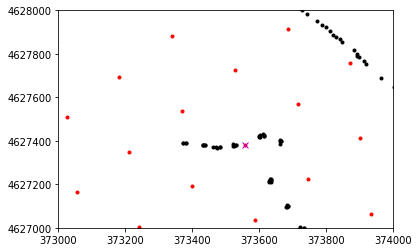

In [11]:
# plot to check that origin == correct coarse grid location
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r');
plt.plot(xpm,ypm,'xm');
plt.xlim((3.73e5,3.74e5))
plt.ylim((4.627e6,4.628e6))

In [12]:
# medium grid box
dxf = dxyf
dyf = dxyf
LMf = 288
MMf = 126
# check to make sure it is divisible by dxc and dyc
print("These numbers should be integers:")
print((LMf-1)*dxf/dxm)
print((MMf-1)*dyf/dym)
# indices in coarse grid for origin of medium grid (found by hand)
row = 3
col = 95
# corresponding coordinates
xpf = Xm[row,col];
ypf = Ym[row,col];
print("Origin of fine grid")
print(xpf,ypf)
print('Fine grid is {} x {}, total = {}'.format(LMf,MMf,LMf*MMf))
Xf,Yf = buildGrid( 0., 0., alp-90., dxf, dyf, LMf, MMf );
Xf = Xf + xpf
Yf = Yf + ypf

These numbers should be integers:
41.0
17.857142857142858
Origin of fine grid
376171.530804 4625323.81169
Fine grid is 288 x 126, total = 36288
Shape of X and Y:  (126, 288) (126, 288)


(4624000.0, 4626000.0)

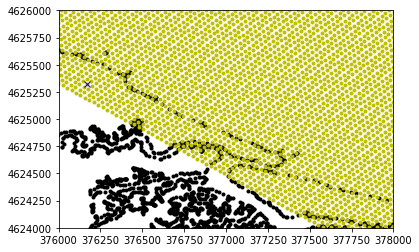

In [13]:
# plot to check that origin == correct coarse grid location
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xm,Ym,'.y');
plt.plot(xpf,ypf,'xb');
plt.xlim((3.760e5,3.78e5))
plt.ylim((4.624e6,4.626e6))

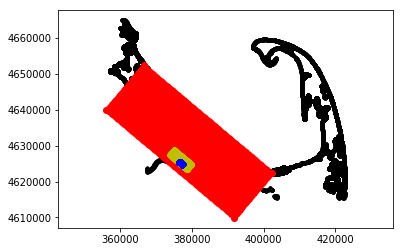

In [14]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(bc[:,0],bc[:,1],'or')
plt.plot(bc[:,0],bc[:,1],'-r')
plt.plot([bc[0,0], bc[3,0]],[bc[0,1], bc[3,1]],'-r')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.axis('equal');

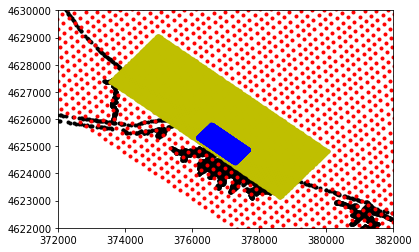

In [15]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.xlim((3.72e5,3.82e5))
plt.ylim((4.622e6,4.63e6));

(4624000.0, 4626000.0)

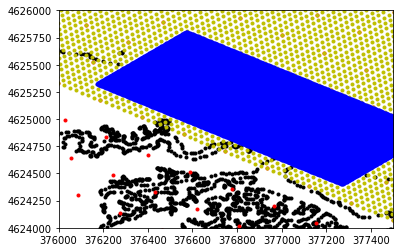

In [16]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(Xc,Yc,'.r')
plt.plot(Xm,Ym,'.y')
plt.plot(Xf,Yf,'.b')
plt.xlim((3.76e5,3.775e5))
plt.ylim((4.624e6,4.626e6))

In [17]:
#### Import the bathymetry data in gridded .tiff files

(4952,) (8215,) (1, 4952, 8215)
Wall time: 4.64 s


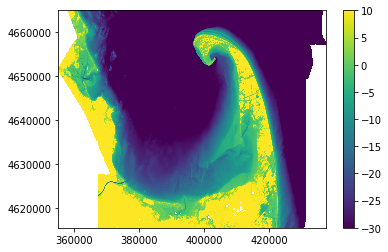

In [18]:
%%time
# Instead of importing as points, import from the tiffs, which allows grid smoothing
'''
# These were exported from Global Mapper from the grids as xyz files
p10 = np.genfromtxt(ddir+'CCBay10m_south_points.txt', delimiter=',')
plidar = np.genfromtxt(ddir+'2013_lidar_points.txt', delimiter=',')
psfm = np.genfromtxt(ddir+'2016-03-30_SandwichTNB_points.txt', delimiter=',')
'''
# This grid was generated by Brian Andrews in ArcGIS
# open the tif with XArray as a DataArray
fn = ddir+'CCBay_10m.tif'
da = xr.open_rasterio(fn)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )

# However, make sure to squeeze before flipping
z10 = np.flipud(np.squeeze(da.values))

# Missing values are -3.40282347e+38. Replace with NaNs as follows:
z10[z10 <= -3.4e+38]=np.NaN

x10 = da['x'].values
y10 = np.flipud(da['y'].values)

plt.pcolormesh(x10,y10,z10,vmin=-30,vmax=10)
plt.colorbar();

(1673,) (2450,) (1, 1673, 2450)


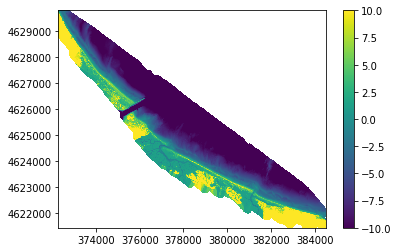

In [19]:
# This grid was generated by CRS GlobalMapper from USACE lidar data
# open the tif with XArray as a DataArray
fn = ddir+'5-m_grid_from_lidar.tif'
da = xr.open_rasterio(fn)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )

# However, make sure to squeeze before flipping
zlidar = np.flipud(np.squeeze(da.values))

# Missing values are -32767. Can replace with NaNs as follows:
zlidar[zlidar<-32766]=np.NaN

xlidar = da['x'].values
ylidar = np.flipud(da['y'].values)

plt.pcolormesh(xlidar,ylidar,zlidar,vmin=-10,vmax=10)
plt.colorbar();

(9858,) (11504,) (1, 9858, 11504)


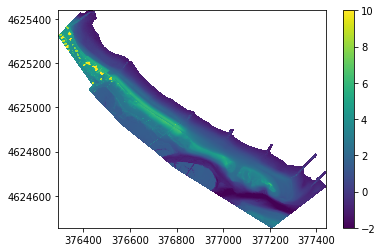

In [20]:
# This grid was generated by CRS in Photoscan
# open the tif with XArray as a DataArray
fn = ddir+'2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif'
da = xr.open_rasterio(fn)

# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )

# However, make sure to squeeze before flipping
zsfm = np.flipud(np.squeeze(da.values))

# Missing values are -32767. Can replace with NaNs as follows:
zsfm[zsfm<-32766]=np.NaN

xsfm = da['x'].values
ysfm = np.flipud(da['y'].values)

plt.pcolormesh(xsfm,ysfm,zsfm,vmin=-2,vmax=10)
plt.colorbar();

#### Here's the plan
* So far, we have generated the x and y values for the coarse, medium, and fine grids
* We have loaded the gridded data (z10, zlidar, and zsfm) as arrays, with vectors for the x and y locations
* Smooth the lidar data
* Smooth and decimate the sfm grid to 0.5 m
* Interpolate sfm data on to fine grid. Should be some NaNs.
* Interpolate lidar data on to fine grid.

* Combine lidar and decimated sfm data into points array. Interpolate onto fine grid
* Cut a hole in the lidar data using the fine grid domain.
* Combine find grid values and holey lidar data into points array. Interpolate onto medium grid



### Smooth the SfM data
Use the Astropy library because it will replace NaNs with values interpolated by the smoothing kernel.

http://docs.astropy.org/en/stable/index.html

In [21]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
# It is a 9x9 array
kernel = Gaussian2DKernel(x_stddev=1)
# astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors
zsfm_s = convolve(zsfm, kernel)

### Decimate the SfM data from 10 cm to 50 cm

(9858, 11504) (1972, 2301) (2301,) (1972,)


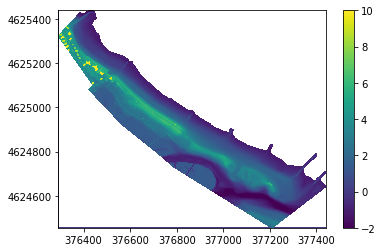

In [22]:
# Decimate the sfm data
zsfm_sd = zsfm_s[::5,::5]
xsfm_d = xsfm[::5]
ysfm_d = ysfm[::5]
print(np.shape(zsfm_s),np.shape(zsfm_sd),np.shape(xsfm_d),np.shape(ysfm_d))
plt.pcolormesh(xsfm_d,ysfm_d,zsfm_sd,vmin=-2,vmax=10)
plt.colorbar();

### Interpolate the SfM data onto the fine grid: ->`Zf1`...with lots of NaNs.

In [36]:
%%time
# Make the fine grid with the SfM data
xp, yp = np.meshgrid(xsfm_d,ysfm_d)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(zsfm_sd)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xf ',np.shape(Xf),'Yf: ' ,np.shape(Yf),'grid points: ',np.shape(np.array((np.ravel(Xf), np.ravel(Yf))).T))

# interpolate data on to fine grid
Zf1 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xf), np.ravel(Yf))).T, method='linear', fill_value=np.NaN, rescale=False)
Zf1 = np.reshape(Zf1,np.shape(Xf))

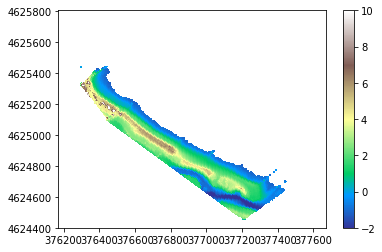

In [212]:
plt.pcolormesh(Xf,Yf,Zf1,vmin=-2,vmax=10,cmap=plt.cm.terrain)
plt.colorbar();

Kernal footprint:  (5, 5)


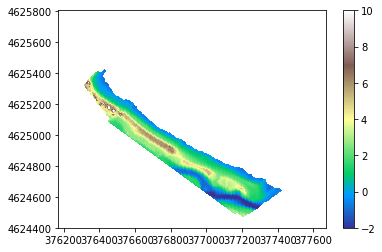

In [211]:
# There are some lone points in this grid. Smoothing with the scipy convolution method spreads out the NaNs
# ...not sure I will use this
from scipy.signal import convolve as scipy_convolve
# Convolution: scipy's direct convolution mode spreads out NaNs (see
# panel 2 below)
kernel = Gaussian2DKernel(x_stddev=.5)
print('Kernal footprint: ',kernel.shape)
Zf1s = scipy_convolve(Zf1, kernel, mode='same', method='direct')
plt.pcolormesh(Xf,Yf,Zf1s,vmin=-2,vmax=10,cmap=plt.cm.terrain)
plt.colorbar();

### Interpolate the lidar data onto the fine grid: -> `Zf2`...no holes.

In [70]:
%%time
# Make the fine grid with lidar data
xp, yp = np.meshgrid(xlidar,ylidar)
xpyp = np.array((np.ravel(xp),np.ravel(yp))).T
zp = np.ravel(zlidar)
print('xp ',np.shape(xp),'yp: ' ,np.shape(yp),'xpyp: ',np.shape(xpyp),'zp: :',np.shape(zp))
print('Xf ',np.shape(Xf),'Yf: ' ,np.shape(Yf),'grid points: ',np.shape(np.array((np.ravel(Xf), np.ravel(Yf))).T))

# interpolate data on to fine grid
Zf2 = interpolate.griddata( xpyp, zp, np.array((np.ravel(Xf), np.ravel(Yf))).T, method='linear', fill_value=np.NaN, rescale=False)
Zf2 = np.reshape(Zf2,np.shape(Xf))

xp  (1673, 2450) yp:  (1673, 2450) xpyp:  (4098850, 2) zp: : (4098850,)
Xf  (126, 288) Yf:  (126, 288) grid points:  (36288, 2)
Wall time: 1min 22s


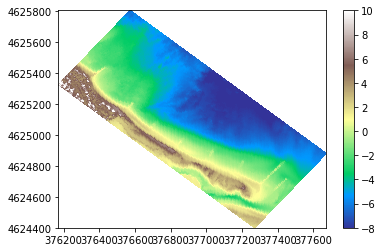

In [207]:
plt.pcolormesh(Xf,Yf,Zf2,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.colorbar();

### Mask out the regions in `Zf2` where `Zf1` has data: -> `Zf3`...has gaps.

In [110]:
Zf_has_sfm = np.array(~np.isnan(Zf1))
Zf_has_lidar = ~Zf_has_sfm
#Zf3 = np.ones_like(Zf2)*np.NaN
Zf3 = Zf2.copy()
Zf3[Zf_has_sfm]=np.NaN

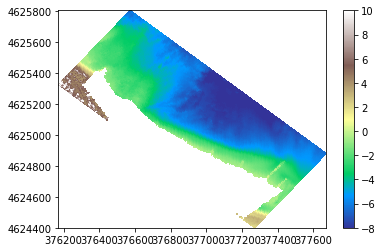

In [208]:
plt.pcolormesh(Xf,Yf,Zf3,vmin=-8,vmax=10,cmap=plt.cm.terrain)
plt.colorbar();

In [223]:
# Make a set of indices where the grids merge.
# Defined as last NaN value in the lidar grid
idx=[]
npoints, ntransects= np.shape(Zf3)
print('ntransects, npoints: ',ntransects,npoints)
for i in range(ntransects):
    j=np.argwhere(np.isnan(Zf3[:,i]))
    if(j.any()):
        idx = np.append(idx,j[-1])
    else:
        idx = np.append(idx,-1)
idx

ntransects, npoints:  288 126


array([ -1.,  -1.,  -1.,  -1.,  33.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  17.,  17.,  43.,  43.,
        43.,  42.,  48.,  51.,  52.,  50.,  49.,  50.,  49.,  48.,  48.,
        40.,  40.,  40.,  39.,  39.,  37.,  37.,  37.,  38.,  38.,  38.,
        37.,  35.,  35.,  35.,  34.,  34.,  34.,  34.,  33.,  33.,  32.,
        32.,  32.,  31.,  31.,  32.,  32.,  32.,  32.,  32.,  32.,  32.,
        32.,  33.,  34.,  35.,  35.,  35.,  36.,  36.,  36.,  37.,  37.,
        36.,  36.,  37.,  36.,  37.,  35.,  37.,  35.,  35.,  36.,  34.,
        33.,  35.,  34.,  33.,  33.,  33.,  33.,  33.,  32.,  32.,  32.,
        32.,  32.,  32.,  32.,  32.,  32.,  31.,  32.,  32.,  31.,  31.,
        31.,  31.,  32.,  32.,  31.,  31.,  32.,  30.,  31.,  31.,  31.,
        30.,  30.,  31.,  31.,  31.,  32.,  32.,  32.,  32.,  33.,  32.,
        32.,  33.,  33.,  33.,  34.,  33.,  33.,  33.,  33.,  34.,  34.,
        33.,  33.,  34.,  34.,  34.,  34.,  35.,  3

In [ ]:
noff = 5
ioff = np.arange(-noff,noff+1,1)
wght= (1.-(ioff+noff)/(2.*noff))
Zm = np.ones_like(Zf1)*np.NaN

for i in range(ntransects):
    if idx[i]>noff:
        k = int(idx[i])-noff
        # print(k)
        swght = np.zeros_like(Zf3[:,i])
        swght[0:k-noff] = 1.
        # print(k-noff,int(k+1+noff))
        swght[k-noff:int(k+1+noff)]=wght
        lwght=1.-swght
        
        # Kludge for some transects
        if(i<20):
            swght = np.zeros_like(Zf3[:,i])
            lwght = np.ones_like(Zf3[:,i])

        Zstack= np.stack(  (Zf1[:,i]*swght,\
                            Zf2[:,i]*lwght) )
        Zmerge = np.nansum(Zstack,0)
        Zm[:,i]=Zmerge

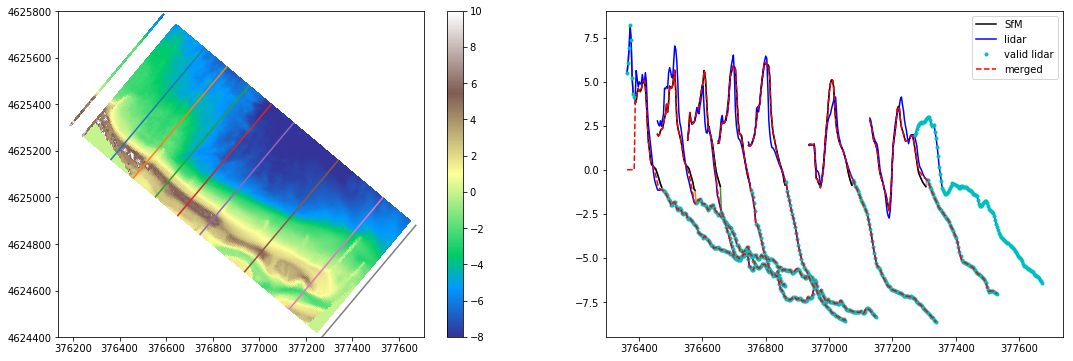

In [239]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xf,Yf,Zm,vmin=-8,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,125,150,200,250,287]):
    plt.plot(Xf[:,i],Yf[:,i],'-')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Zf5[:,i],'-')

    plt.plot(Xf[:,i],Zf1[:,i],'-k')
    plt.plot(Xf[:,i],Zf2[:,i],'-b')
    plt.plot(Xf[:,i],Zf3[:,i],'.c')
    plt.plot(Xf[:,i],Zm[:,i],'--r')
    #plt.xlim(idx[i]-20,idx[i]+20)

# one last transect to get the legend
i=287
plt.plot(Xf[:,i],Zf1[:,i],'-k',label='SfM')
plt.plot(Xf[:,i],Zf2[:,i],'-b',label='lidar')
plt.plot(Xf[:,i],Zf3[:,i],'.c',label='valid lidar')
plt.plot(Xf[:,i],Zm[:,i],'--r',label='merged')
#plt.xlim(idx[i]-20,idx[i]+20)
plt.legend();

### Make a complete grid by `nansum`ing the two grids.

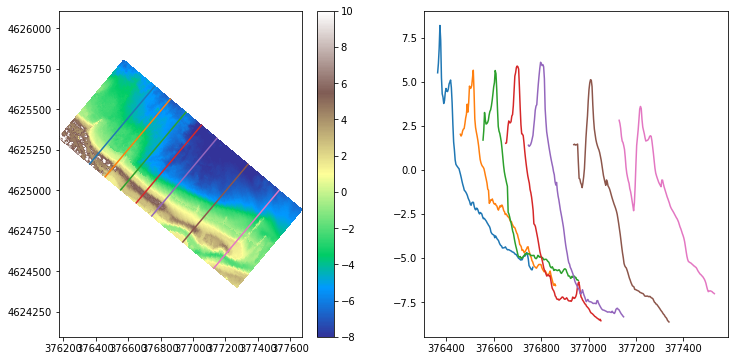

In [128]:
Zstack = np.stack((Zf1,Zf3))
Zf5 = np.nanmean(Zstack, 0)

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xf,Yf,Zf5,vmin=-8,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Yf[:,i],'-')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Zf5[:,i],'-')

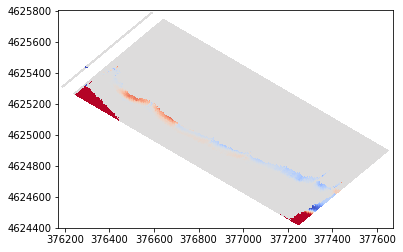

In [237]:
plt.pcolormesh(Xf,Yf,Zf5-Zm,vmin=-2,vmax=2,cmap=plt.cm.coolwarm)

(17, 17)


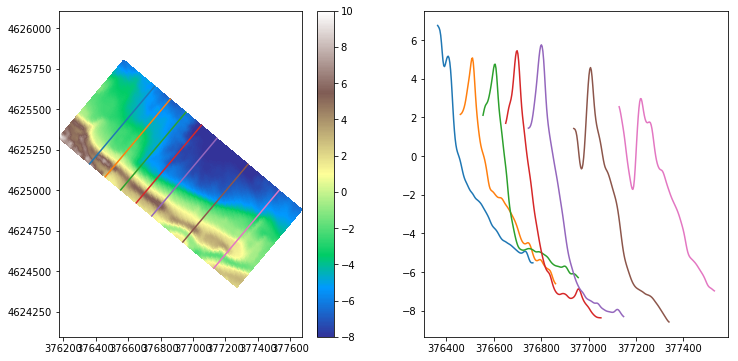

In [133]:
# Use the astropy convolution to expand the region including lidar data
kernel = Gaussian2DKernel(x_stddev=2)
print(kernel.shape)
# astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors
Zf6 = convolve(Zf5, kernel,boundary='extend')

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pcolormesh(Xf,Yf,Zf6,vmin=-8,vmax=10,cmap=plt.cm.terrain)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Yf[:,i],'-')
plt.colorbar()
plt.axis('equal');
plt.subplot(1,2,2)
for i in np.array([50,75,100,125,150,200,250]):
    plt.plot(Xf[:,i],Zf6[:,i],'-');

(17, 17)


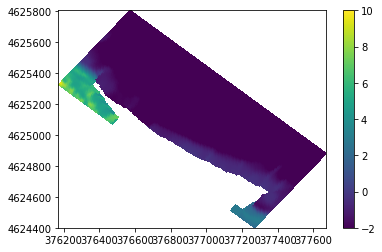

In [106]:
# Use the astropy convolution to expand the region including lidar data
kernel = Gaussian2DKernel(x_stddev=1)
print(kernel.shape)
# astropy's convolution replaces the NaN pixels with a kernel-weighted
# interpolation from their neighbors
Zf4 = convolve(Zf3, kernel,boundary='extend')
plt.pcolormesh(Xf,Yf,Zf4,vmin=-2,vmax=10)
plt.colorbar();

In [112]:
Zstack = np.stack((Zf1,Zf4))
Zf5 = np.nanmean(Zstack, 0)

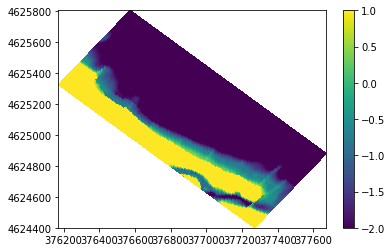

In [108]:
plt.pcolormesh(Xf,Yf,Zf5,vmin=-2,vmax=1)
plt.colorbar();

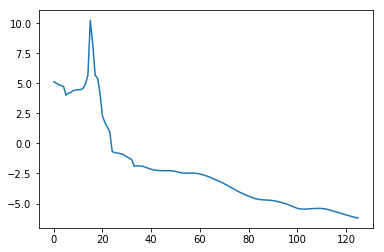

In [109]:
plt.plot(Zf5[:,60])